# SSPRK Eigenvalue Analysis

Consider a simple model problem:
\begin{align*}
    \frac{\partial \zeta}{\partial t} &= -c \frac{\partial u}{\partial x}, \\
    \frac{\partial u}{\partial t} &= -c \frac{\partial \zeta}{\partial x}.
\end{align*}
Note that this is similar to the 1D linearized SWEs with the Coriolis term deleted.

With the goal of applying a von Neumann stability anaysis, we can apply a Fourier transform in $x$ to the above to get
\begin{align*}
    \frac{\partial \hat{\zeta}}{\partial t} &= -i \omega \hat{u}, \\
    \frac{\partial \hat{u}}{\partial t} &= -i \omega \hat{\zeta},
\end{align*}
where $\omega = ck$ for a given wavenumber $k$. Also, from now on, write $u = \hat{u}$ and $\zeta = \hat{\zeta}$ to ease notation.

Chose a time-step $\Delta t$ and let $\alpha = \omega\Delta t = ck\Delta t$. The SSPRK3 algorithm for this system is then given by:
\begin{align*}
    \bar{\zeta}^{n+1} &= \zeta^n - i \alpha u^n \\
    \bar{u}^{n+1} &= u^n - i \alpha \zeta^n \\
    & \\
    \bar{\zeta}^{n+1/2} &= \frac{3}{4}\zeta^n + \frac{1}{4}\left( \bar{\zeta}^{n+1} - i \alpha  \bar{u}^{n+1} \right) \\
    \bar{u}^{n+1/2} &= \frac{3}{4}u^n + \frac{1}{4}\left( \bar{u}^{n+1} - i \alpha  \bar{\zeta}^{n+1} \right) \\
    & \\
    \zeta^{n+1} &= \frac{1}{3}\zeta^n + \frac{2}{3}\left( \bar{\zeta}^{n+1/2} - i \alpha \bar{u}^{n+1/2} \right) \\
    u^{n+1} &= \frac{1}{3}u^n + \frac{2}{3}\left( \bar{u}^{n+1/2} - i \alpha \bar{\zeta}^{n+1/2} \right).
\end{align*}

In [2]:
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
%matplotlib inline


# define relevent symbols 
#     _u = u^n, _zeta = \zeta^n
#     U1 = \bar{u}^{n+1}, ZETA1 = \bar{\zeta}^{n+1}
#     U2 = \bar{u}^{n+1/2}, ZETA3 = \bar{\zeta}^{n+1/2}
#     u = u^{n+1}, zeta = \zeta^{n+1}
_u, _zeta = symbols('u^n \zeta^n')
lam, alpha = symbols('lambda alpha')

# define time-stepping scheme
ZETA1 = _zeta - I*alpha*_u
U1 = _u - I*alpha*_zeta

ZETA2 = (3/4)*_zeta + (1/4) * ( ZETA1 - I*alpha*U1 )
U2 = (3/4)*_u + (1/4) * ( U1 - I*alpha*ZETA1 )

zeta = (1/3)*_zeta + (2/3) * ( ZETA2 - I*alpha*U2 )
u = (1/3)*_u + (2/3) * ( U2 - I*alpha*ZETA2 )

# simplify the expressions for zeta and u 
zeta  = nsimplify( zeta.simplify() )
u = nsimplify( u.simplify() )

Now, we have a system of linear equations in $\zeta^n$ and $u^n$. We can find the amplification matrix for the scheme by writing it in the form
$$ \mathbf{w}^{n+1} = G \mathbf{w}^n, $$
where $G$ is the amplification matrix and $\mathbf{w}^* = (\zeta^*, u^*)^T$.

We care about the amplification matrix $G$ as it follows from the above that $\mathbf{w}^n = G^n \mathbf{w}^0$. In turn, it follows that the solution $\mathbf{w}^n$ is bounded as $ n \to \infty$ if and only if $||G^n||$ is bounded as $n \to \infty$.

In [3]:
# create the amplification matrix G
_w = [_zeta, _u]
w = [zeta, u]
G, _ = linear_eq_to_matrix(w, _w)

G

Matrix([
[        1 - alpha**2/2, I*alpha**3/6 - I*alpha],
[I*alpha**3/6 - I*alpha,         1 - alpha**2/2]])

In [4]:
p = G.charpoly(lam).as_expr()
p

alpha**6/36 - alpha**4/12 + lambda**2 + lambda*(alpha**2 - 2) + 1

nu^max ~ 1.76714586764426


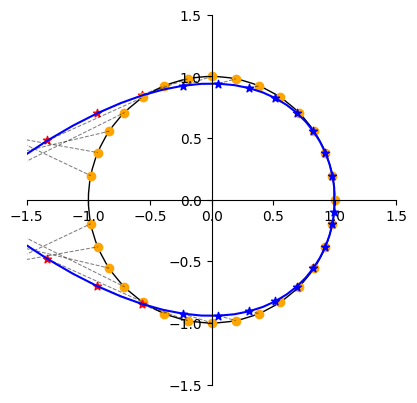

In [5]:
optP = p


fig, ax = plt.subplots(1)

ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('center')
ax.spines['top'].set_color('none')

axLim = 1.5
ax.set_xlim(-axLim, axLim)
ax.set_ylim(-axLim, axLim)
ax.set_aspect(1)

unitCircle = plt.Circle((0, 0), 1, fill=False, alpha=1)
ax.add_artist(unitCircle)

approx_real = []
approx_imag = []
badNus =[]

for k in np.arange(-16.0, 16.0, 0.5):
    if k < 0 and k != 0:
        approx = complex(solve(optP.subs(alpha, k*pi/16), lam)[0])
    elif k != 0:
        approx = complex(solve(optP.subs(alpha, k*pi/16), lam)[1])
    # END if
    approx_real.append( approx.real )
    approx_imag.append( approx.imag )
    
    exact = complex(exp(I*k*pi/16).evalf())
    
    absValApprox = sqrt(approx.real**2 + approx.imag**2)
    if absValApprox > 1: badNus.append(k*pi/16) 

    if ( np.isclose(k%1, 0) or np.isclose(k%1, 1) ) and np.abs(k*pi/16) <= np.pi:
        # plot exact and approx eigen values
        colo = 'blue' if absValApprox <= 1 else 'red'
        ax.scatter(exact.real, exact.imag, marker='o', color='orange')
        ax.scatter(approx.real, approx.imag, marker='*', color=colo)
        # connect exact to approx with dashed line
        reals = [approx.real, exact.real]
        imags = [approx.imag, exact.imag]
        ax.plot(reals, imags, color='black', linestyle='dashed', linewidth=0.75, alpha=0.5)
    # END if
# END for

ax.plot(approx_real, approx_imag, color='blue')
try:
    print( 'nu^max ~ {}'.format( np.min(np.abs(badNus)).evalf() ) )
except: pass

In the above, we see that the eigenvalues leave the unit circle (the method becomes unstable), when
$$ \alpha_\text{max} \approx 1.76714586764426 $$

Now consider SSPRK3 applied to the linearized SWEs:
Set $K = 2 \sin\left(k\frac{\Delta x}{2}\right)$, $L = 2 \sin\left(\ell\frac{\Delta y}{2}\right)$, and $\tilde{\phi} = f\cos\left(k\frac{\Delta x}{2}\right)\cos\left(\ell\frac{\Delta y}{2}\right)$. Then, the Fourier transformed, spatially discretized (C-grid), linear SWEs, become
\begin{align*}
    \frac{\partial \hat{u}}{\partial t} &= \tilde{\phi}\hat{v} - i \frac{cK}{\Delta x}\hat{\eta} \\
    \frac{\partial \hat{v}}{\partial t} &= -\tilde{\phi}\hat{u} - i \frac{cL}{\Delta y}\hat{\eta} \\
    \frac{\partial \hat{\eta}}{\partial t} &= -i \left( \frac{cK}{\Delta x}\hat{u} + \frac{cL}{\Delta y}\hat{v} \right).
\end{align*}

This looks like:
\begin{align*}
    \bar{u}^{n+1} &= u^n  + \left( \phi v^n - iK\nu_x\eta^n  \right) \\
    \bar{v}^{n+1} &= v^n  + \left( -\phi u^n - iK\nu_x\eta^n  \right) \\
    \bar{\eta}^{n+1} &= \eta^n - i \left( K\nu_x u^n + L \nu_y v^n  \right) \\
    & \\
    \bar{u}^{n+1/2} &= \frac{3}{4}u^n  + \frac{1}{4}\left[\bar{u}^{n+1} + \left( \phi \bar{v}^{n+1} - iK\nu_x\bar{\eta}^{n+1}  \right)\right] \\
    \bar{v}^{n+1/2} &= \frac{3}{4}v^n  + \frac{1}{4}\left[\bar{v}^{n+1} + \left( -\phi \bar{u}^{n+1} - iL\nu_y\bar{\eta}^{n+1}  \right)\right] \\
    \bar{\eta}^{n+1/2} &= \frac{3}{4}\eta^n + \frac{1}{4}\left[\bar{\eta}^{n+1} - i\left( K\nu_x \bar{u}^{n+1} + L\nu_y\bar{v}^{n+1}  \right)\right] \\
    & \\
    u^{n+1} &= \frac{1}{3}u^n  + \frac{2}{3}\left[\bar{u}^{n+1/2} + \left( \phi \bar{v}^{n+1/2} - iK\nu_x\bar{\eta}^{n+1/2}  \right)\right] \\
    v^{n+1} &= \frac{1}{3}v^n  + \frac{2}{3}\left[\bar{v}^{n+1/2} + \left( -\phi \bar{u}^{n+1/2} - iL\nu_y\bar{\eta}^{n+1/2}  \right)\right] \\
    \eta^{n+1} &= \frac{1}{3}\eta^n + \frac{2}{3}\left[\bar{\eta}^{n+1/2} - i\left( K\nu_x \bar{u}^{n+1/2} + L\nu_y\bar{v}^{n+1/2}  \right)\right]
\end{align*}

In [13]:
# define relevent symbols 
#     _u = u^n, _v = v^n, _eta = \eta^n
#     U1 = \bar{u}^{n+1/3}, V1 = \bar{v}^{n+1/3}, ETA1= \bar{\eta}^{n+1/3}
#     U2 = \bar{u}^{n+1/2}, V2 = \bar{v}^{n+1/2}, ETA2= \bar{\eta}^{n+1/2}
#     u = u^{n+1}, v = v^{n+1}, eta = \eta^{n+1}
_u, _v, _eta = symbols('u^n v^n eta^n')
lam = symbols('lambda')
nux, nuy, K, L, phi = symbols('nu_x nu_y K L phi')


U1 = _u + (phi*_v - I*K*nux*_eta)
V1 = _v + (-phi*_u - I*L*nuy*_eta)
ETA1 = _eta - I*(K*nux*_u + L*nuy*_v)

U2 = (3/4)*_u + (1/4)*( U1 + (phi*V1 - I*K*nux*ETA1) )
V2 = (3/4)*_v + (1/4)*( V1 + (-phi*U1 - I*L*nuy*ETA1) )
ETA2 = (3/4)*_eta + (1/4)*( ETA1 - I*(K*nux*U1 + L*nuy*V1)  )

u = (1/3)*_u + (2/3)*( U2 + (phi*V2 - I*K*nux*ETA2) )
v = (1/3)*_v + (2/3)*( V2 + (-phi*U2 - I*L*nuy*ETA2) )
eta = (1/3)*_eta + (2/3)*( ETA2 - I*(K*nux*U2 + L*nuy*V2) )

In [14]:
# create the amplification matrix G
_w = [_u, _v, _eta]
w = [u, v, eta]
_G, _ = linear_eq_to_matrix(w, _w)

# We are going to store G as a numpy ndarray, rather than a sympy
# matrix as we have in previous notebooks because the symbolic
# representation is too complicated to be meaningful and this
# is much faster.
x = [nux, nuy, K , L, phi]
_calcG = lambdify(x, _G)


# We build Gtilde using scipy, not sympy -- the symbolic calculation
# of e^{A\Delta t} takes too long (~4 hours). The symbolic expression 
# is too complicated to be meaningful to a human anyway.
def _calcGtilde(nux, nuy, Ktilde, Ltilde, fdt):
    Adt = np.matrix( [[0, fdt, -1j*Ktilde*nux],
                      [-fdt, 0, -1j*Ltilde*nuy],
                      [-1j*Ktilde*nux, -1j*Ltilde*nuy, 0]] )
    return sp.linalg.expm(Adt)
# END calcGtilde()


KtildeVal = np.pi/2
LtildeVal = KtildeVal
fdtVal = 1/2

KVal = 2*np.sin(KtildeVal/2)
LVal = KVal
phiVal = fdtVal*np.cos(KtildeVal/2)*np.cos(LtildeVal/2)

G = lambda nu: _calcG(nu, nu, KVal, LVal, phiVal)
Gtilde = lambda nu: _calcGtilde(nu, nu, KtildeVal, LtildeVal, fdtVal)


# Define a function to sort eigenvalues so we know which to compare
def parseEigVals(eigVals):
    eigValDict = {}
    reals = []
    for eigVal in eigVals:
        if np.isclose(eigVal, 1.0+0.0j):
            eigValDict['one'] = eigVal
        elif not np.isclose(eigVal.imag, 0.0):
            if eigVal.imag > 0:
                eigValDict['pos'] = eigVal
            else:
                eigValDict['neg'] = eigVal
        else:
            reals.append(eigVal.real)
            eigValDict['real'] = reals
        # END if
    # END for
    return eigValDict
#END parseEigVals()


# Define a function to create a plot comparing exact/numerical eigenvalues
def eigValPlot(Gtilde, G, a=-16, b=16, delta=1e-2, nuDotLimit=np.pi/3):
    fig, ax = plt.subplots(1)

    ax.spines['left'].set_position('center')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('center')
    ax.spines['top'].set_color('none')

    axLim = 1.5
    ax.set_xlim(-axLim, axLim)
    ax.set_ylim(-axLim, axLim)
    ax.set_aspect(1)

    unitCircle = plt.Circle((0, 0), 1, fill=False, color='orange')
    ax.add_artist(unitCircle)

    approx_real = []
    approx_imag = []
    badNus =[]
    count = 0

    for k in np.arange(a, b, delta):
        nu = k*np.pi/16
        # get complex values for exact and approx eigen values
        GtildeEigVals = parseEigVals( sp.linalg.eigvals( Gtilde(nu) ) )
        GEigVals = parseEigVals( sp.linalg.eigvals( G(nu) ) )

        if np.isclose(nu, 0):
            exact = GtildeEigVals['one']
            approx = GEigVals['one']
            #approx = GEigVals['real'][0]
        else:
            key = 'pos' if nu > 0 else 'neg'
            exact = GtildeEigVals[key]
            if key in GEigVals.keys():
                approx = GEigVals[key]
            else:
                if len(GEigVals['real']) == 1:
                    approx = GEigVals['real'][0]
                else:
                    ind = 1 if nu >= 0 else 0
                    approx = GEigVals['real'][ind]
                # END if
            # END if
        # END if
        approx_real.append( approx.real )
        approx_imag.append( approx.imag )
        
        absValApprox = sqrt(approx.real**2 + approx.imag**2)
        if absValApprox > 1: badNus.append(nu) 
        
        if ( np.isclose(k%1, 0) or np.isclose(k%1, 1) ) and np.abs(nu) <= nuDotLimit:
            # plot exact and approx eigen values
            colo = 'blue' if absValApprox <= 1 else 'red'
            ax.scatter(exact.real, exact.imag, marker='o', color='orange')
            ax.scatter(approx.real, approx.imag, marker='*', color=colo)
            # connect exact to approx with dashed line
            reals = [approx.real, exact.real]
            imags = [approx.imag, exact.imag]
            ax.plot(reals, imags, color='black', linestyle='dashed', linewidth=0.75, alpha=0.5)
        # END if
    # END for

    ax.plot(approx_real, approx_imag, color='blue')
    try:
        print( 'nu^max ~ {}'.format( np.min(np.abs(badNus)) ) )
    except: pass
# END eigValPlot()

nu^max ~ 0.8580474935116267


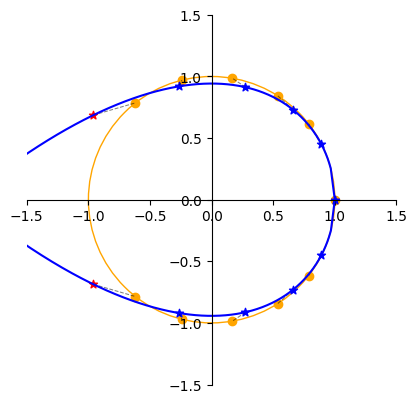

In [15]:
eigValPlot(Gtilde, G)